In [17]:
from IPython.display import display
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.decomposition import DictionaryLearning, MiniBatchDictionaryLearning
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

In [18]:
# Plotting functions
def plot_function(ax, idx, x_mean, x_variance, minmax, title, label=None):
    sns.lineplot(ax=ax, data=x_mean)
    if x_variance is not None:
        plt.fill_between(x_mean - x_variance, x_mean + x_variance)
    ax.set_ylim([-minmax, minmax])
    if label is None:
        ax.set_title(f"{title} {idx}")
    else:
        ax.set_title(f"{title} {idx}, class={label}")    

def plot_reconstruction(ax, x, r, minmax):
    sns.lineplot(ax=ax, data=x)
    sns.lineplot(ax=ax, data=r)
    ax.legend(["original", "reconstruction"])
    error = np.sqrt(np.linalg.norm(x - r))
    ax.set_title(f"Reconstrunction error {error:.3f}")
    ax.set_ylim([-minmax, minmax])

def plot_functions(rows, cols, X_mean, X_variance, y, minmax, title):
    fig, axs = plt.subplots(rows, cols, figsize=(cols*10, rows*5))
    axs = axs.flatten()
    for i, ax in enumerate(axs):
        label = y[i] if y is not None else None
        x_variance = X_variance[i, :] if X_variance is not None else None
        plot_function(ax=ax, idx=i + 1, x_mean=X_mean[i, :], x_variance=x_variance, minmax=minmax, title=title, label=label)
    
def plot_signals(rows, cols, X, y):
    minmax = np.max(np.abs(X))
    plot_functions(rows, cols, X, None, y, minmax, "Signal")
        
def plot_bases(rows, cols, D_mean, D_var=None):
    minmax = np.max(np.abs(D_mean))
    plot_functions(rows, cols, D_mean, D_var, None, minmax, "Basis function")

def plot_coefficient_vector(ax, idx, z, minmax):
    ax.stem(range(len(z)), z)
    ax.set_title(f"Coefficients for signal {idx}")
    ax.set_ylim([-minmax, minmax])

def plot_coefficients(rows, cols, Z):
    fig, axs = plt.subplots(rows, cols, figsize=(cols*10, rows*5))
    axs = axs.flatten()
    minmax_z = np.max(np.abs(Z))
    for i, ax in enumerate(axs):
        plot_coefficient_vector(ax, idx=i + 1, z=Z[i, :], minmax=minmax_z)
    
def plot_resonstructions_with_coefficients(idxs, X, R, Z):
    fig, axs = plt.subplots(len(idxs), 2, figsize=(20, 5 * len(idxs)))
    axs = axs.flatten()
    minmax_x = np.max(np.abs(X))
    minmax_z = np.max(np.abs(Z))
    for i, idx in enumerate(idxs):
        plot_reconstruction(ax=axs[2 * i], x=X[idx, :], r=R[idx, :], minmax=minmax_x)
        plot_coefficient_vector(ax=axs[2 * i + 1], idx=idx, z=Z[idx, :], minmax=minmax_z)

Train shape: (400, 100)
Test shape:  (400, 100)


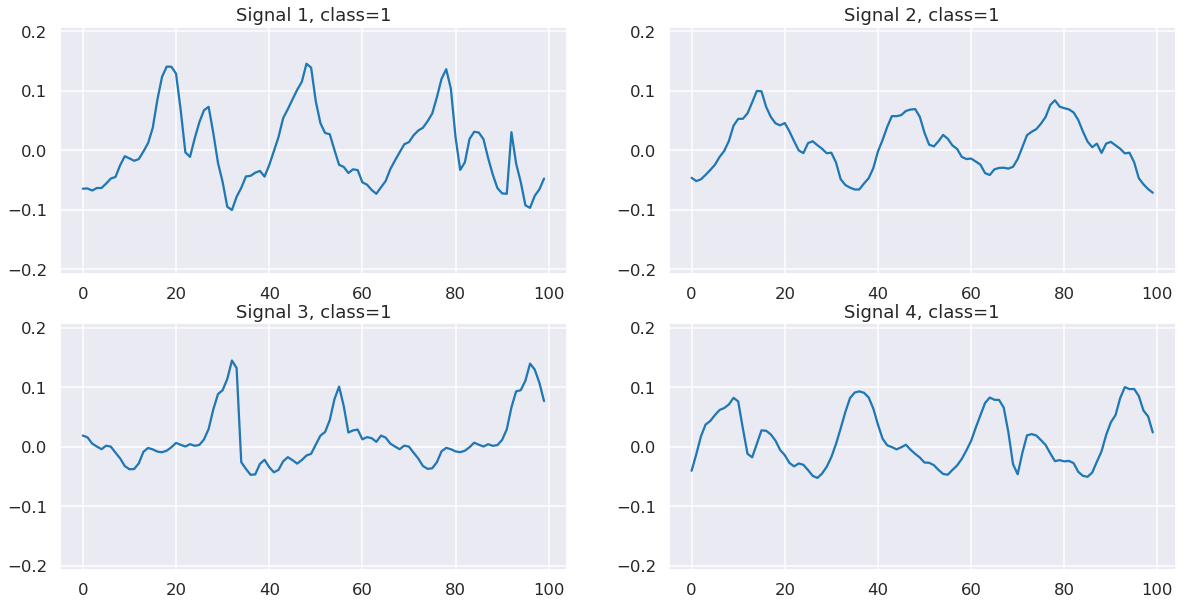

In [19]:
data = loadmat('accelerometer_data.mat')
X_train = data['train_x']
y_train = data['train_y'].ravel()
X_test = data['test_x']
y_test = data['test_y'].ravel()

# For now, let's just use data from class 1, and subsample the rows/cols
rows = 400
cols = 100
X_train = X_train[y_train==1, :cols]
y_train = y_train[y_train==1]
idx_train = np.random.permutation(len(y_train))[:rows]
X_train = X_train[idx_train, :]
y_train = y_train[idx_train]

X_test = X_test[y_test==1, :cols]
y_test = y_test[y_test==1]
idx_test = np.random.permutation(len(y_test))[:rows]
X_test = X_test[idx_test, :]
y_test = y_test[idx_test]


[m_train, n] = X_train.shape
m_test = X_test.shape[0]
print(f"Train shape: {X_train.shape}")
print(f"Test shape:  {X_test.shape}")

norms = np.linalg.norm(X_train, axis=0)
X_train = X_train / norms
X_test = X_test / norms

plot_signals(2, 2, X_train, y_train)

In [20]:
k = 16
# dico = DictionaryLearning(n_components=k, alpha=0.1)
dico = MiniBatchDictionaryLearning(n_components=k, alpha=0.1, n_iter=500)
dico.fit(X_train)
D = dico.components_
Z = dico.transform(X_train)

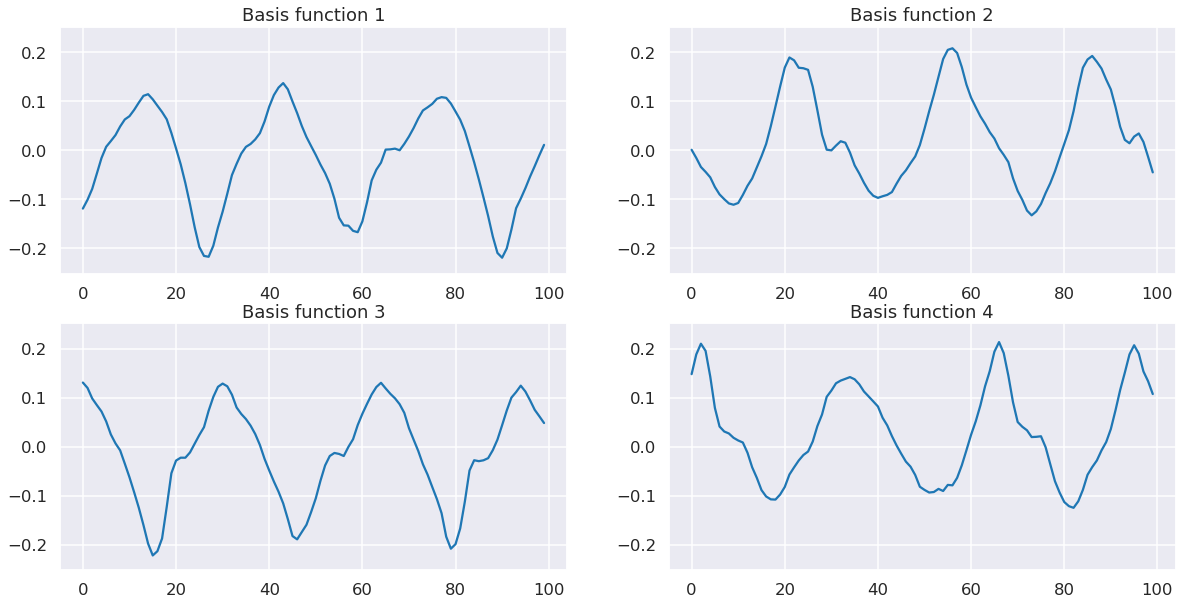

In [21]:
# Print some of the bases, ordered by their rank
Z_rank = np.argsort(np.mean(np.abs(Z), axis=0))[::-1]
plot_bases(2, 2, D[Z_rank, :])

In [22]:
# Reconstruct it frame-by-frame using a linear combination of 20 atoms per frame (sparsity-constrained OMP)
from sklearn.decomposition import SparseCoder
coder = SparseCoder(dictionary=D, transform_n_nonzero_coefs=2, transform_alpha=None, transform_algorithm="omp")
Z_test = coder.transform(X_test)
R_test = np.dot(Z_test, D)

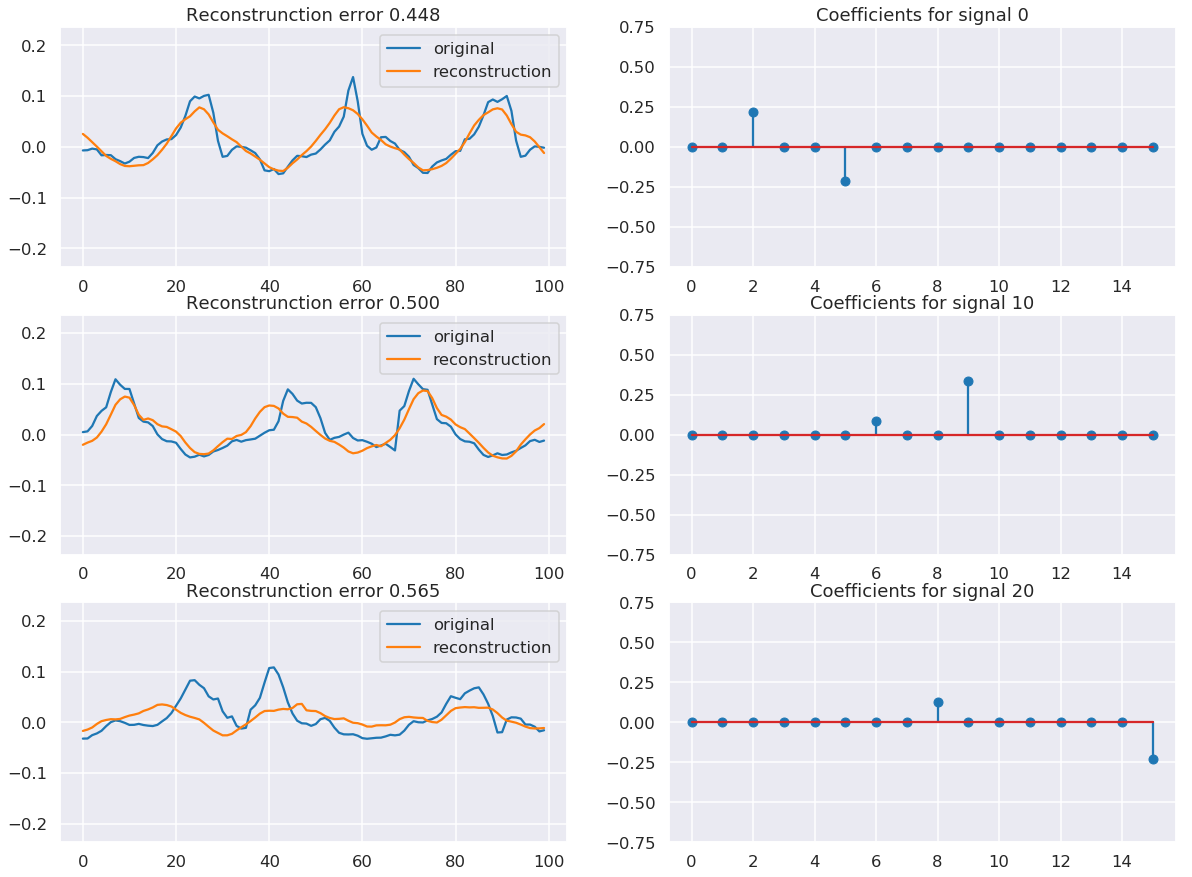

In [23]:
# Plot a couple of reconstructions along with the coefficient vectors
idxs = [0, 10, 20]
plot_resonstructions_with_coefficients(idxs, X_test, R_test, Z_test)

In [28]:
import mxfusion as mf
import mxnet as mx
print(mf.__version__)

from mxfusion import Model, Variable
from mxfusion.components.distributions import Normal, MultivariateNormal, Laplace, Gamma, NormalMeanPrecision
from mxfusion.components.functions.operators import dot
from mxfusion.components.variables import PositiveTransformation, VariableType
from mxfusion.components.functions import MXFusionGluonFunction
from mxfusion.components.functions.operators import broadcast_to
from mxfusion.inference import StochasticVariationalInference, BatchInferenceLoop
from mxfusion.inference.grad_based_inference import GradBasedInference
from mxfusion.inference.meanfield import create_Gaussian_meanfield
from mxfusion.models import Model, Posterior
from mxfusion.util.inference import variables_to_UUID
from mxfusion.inference import VariationalPosteriorForwardSampling

# Monkey patch modified factor printing
from mxfusion.components import Factor
def print_factor(self):
    out_str = self.__class__.__name__
    if self.predecessors is not None:
        out_str += '(' + ', '.join([str(name) + '=' + str(var) for name, var in self.predecessors]) \
                   + (f", shape={self.outputs[0][1].shape})" if len(self.outputs) == 1 else ')')
    return out_str
Factor.__repr__ = print_factor

zero = mx.nd.array([0])
one = mx.nd.array([1])

X_train_mx = mx.nd.array(X_train)
X_test_mx = mx.nd.array(X_test)

0.3.1a


In [29]:
# MXFusion model
k = 16
print(f"m: {m_train}, n: {n}, k: {k}")

model = Model()
model.Z = Laplace.define_variable(location=broadcast_to(zero, (m_train, k)), scale=broadcast_to(one * 1e-1, (m_train, k)), shape=(m_train, k))  
# model.Z = Normal.define_variable(mean=broadcast_to(zero, (m_train, k)), variance=broadcast_to(one, (m_train, k)), shape=(m_train, k))  
model.D = Normal.define_variable(mean=broadcast_to(zero, (k, n)), variance=broadcast_to(one * 1e3, (k, n)), shape=(k, n))
# sigma_2 = Variable(shape=(1,), transformation=PositiveTransformation())
# model.X = Normal.define_variable(mean=dot(model.Z, model.D), variance=broadcast_to(sigma_2, (m_train, n)), shape=(m_train, n))
model.tau = Gamma.define_variable(alpha=1., beta=1., shape=(1,))
model.X = NormalMeanPrecision.define_variable(mean=dot(model.Z, model.D), precision=broadcast_to(model.tau, (m_train, n)), shape=(m_train, n))

print(model)

m: 400, n: 100, k: 16
Model (857b0)
Variable tau (45b85) ~ Gamma(alpha=Variable (7a3e1), beta=Variable (9b7ab), shape=(1,))
Variable (9706b) = BroadcastToOperator(data=Variable tau (45b85), shape=(1,))
Variable (632cf) = BroadcastToOperator(data=Variable (02878), shape=(1,))
Variable (ac53c) = BroadcastToOperator(data=Variable (ed4f8), shape=(1,))
Variable D (36492) ~ Normal(mean=Variable (ac53c), variance=Variable (632cf), shape=(16, 100))
Variable (03d2e) = BroadcastToOperator(data=Variable (7fc27), shape=(1,))
Variable (75731) = BroadcastToOperator(data=Variable (bc3c2), shape=(1,))
Variable Z (eed51) ~ Laplace(location=Variable (75731), scale=Variable (03d2e), shape=(400, 16))
Variable (caae8) = CustomOperator(x=Variable Z (eed51), y=Variable D (36492), shape=(1,))
Variable X (929b8) ~ NormalMeanPrecision(mean=Variable (caae8), precision=Variable (9706b), shape=(400, 100))


In [30]:
q = Posterior(model)

D_init = mx.nd.random_normal(shape=model.D.shape)
Z_init = mx.nd.random_normal(shape=model.Z.shape)

z_mean = Variable(shape=model.Z.shape, initial_value=mx.nd.zeros_like(Z_init))
z_var = Variable(shape=model.Z.shape, transformation=PositiveTransformation(), initial_value=mx.nd.ones_like(Z_init) * 1e-1)
d_mean = Variable(shape=model.D.shape, initial_value=mx.nd.zeros_like(D_init))
d_var = Variable(shape=model.D.shape, transformation=PositiveTransformation(), initial_value=mx.nd.ones_like(D_init) * 1e-3)

q.Z.set_prior(Normal(mean=z_mean, variance=z_var))
q.D.set_prior(Normal(mean=d_mean, variance=d_var))
q.tau.set_prior(Normal(mean=0, variance=1))
# q.X.set_prior(NormalMeanPrecision(mean=0, precision=Variable(shape=(1,), transformation=PositiveTransformation())))

print(model.X.shape)

svi = StochasticVariationalInference(model=model, num_samples=10, observed=[model.X], posterior=q)
infr1 = GradBasedInference(inference_algorithm=svi, grad_loop=BatchInferenceLoop())
infr1.initialize(X=X_train_mx, D=D_init, Z=Z_init)

(400, 100)


/Users/tdiethe/code/MXFusion/examples/notebooks/mxfusion/inference/inference_parameters.py:71: UserWarning: InferenceParameters has already been initialized.  The existing one will be overwritten.
  warnings.warn("InferenceParameters has already been initialized.  The existing one will be overwritten.")


In [31]:
infr1.run(X=X_train_mx, optimizer='adam', learning_rate=1e-1, max_iter=500, verbose=True)
Z_post_mean = infr1.params[q.Z.factor.mean].asnumpy()
Z_post_var = infr1.params[q.Z.factor.variance].asnumpy()
D_post_mean = infr1.params[q.D.factor.mean].asnumpy()
D_post_var = infr1.params[q.D.factor.mean].asnumpy()

assert not np.any(np.isnan(D_post_mean))
assert not np.any(np.isnan(D_post_var))
assert not np.any(np.isnan(Z_post_mean))
assert not np.any(np.isnan(Z_post_var))

/Users/tdiethe/code/MXFusion/examples/notebooks/mxfusion/inference/inference.py:155: UserWarning: Trying to initialize the inference twice, skipping.
  warnings.warn("Trying to initialize the inference twice, skipping.")


ValueError: nan value in loss

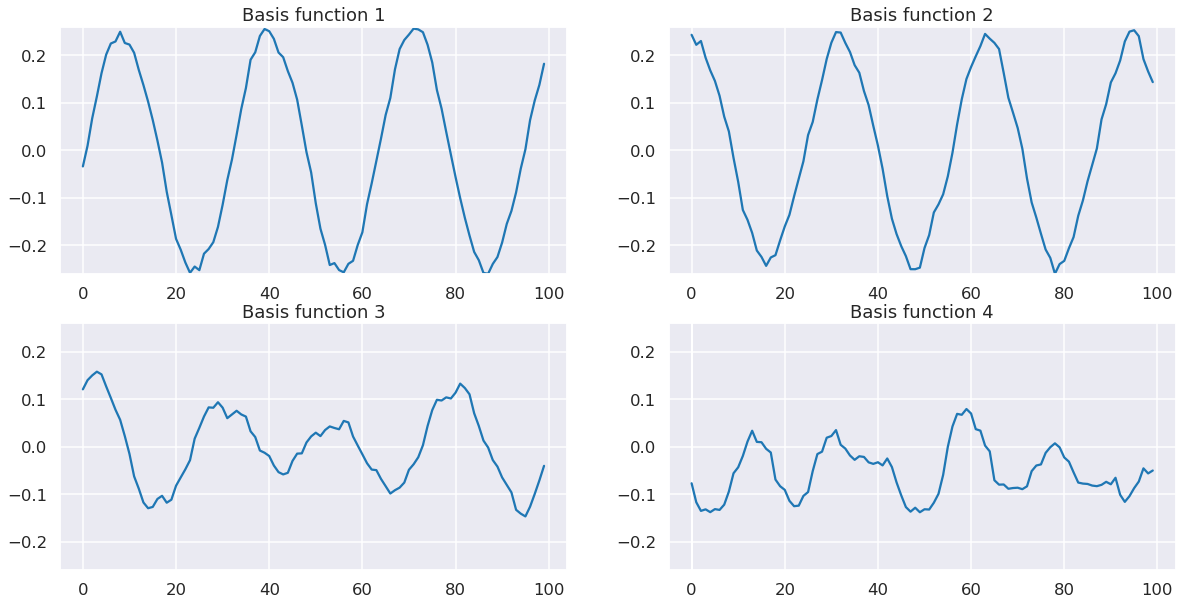

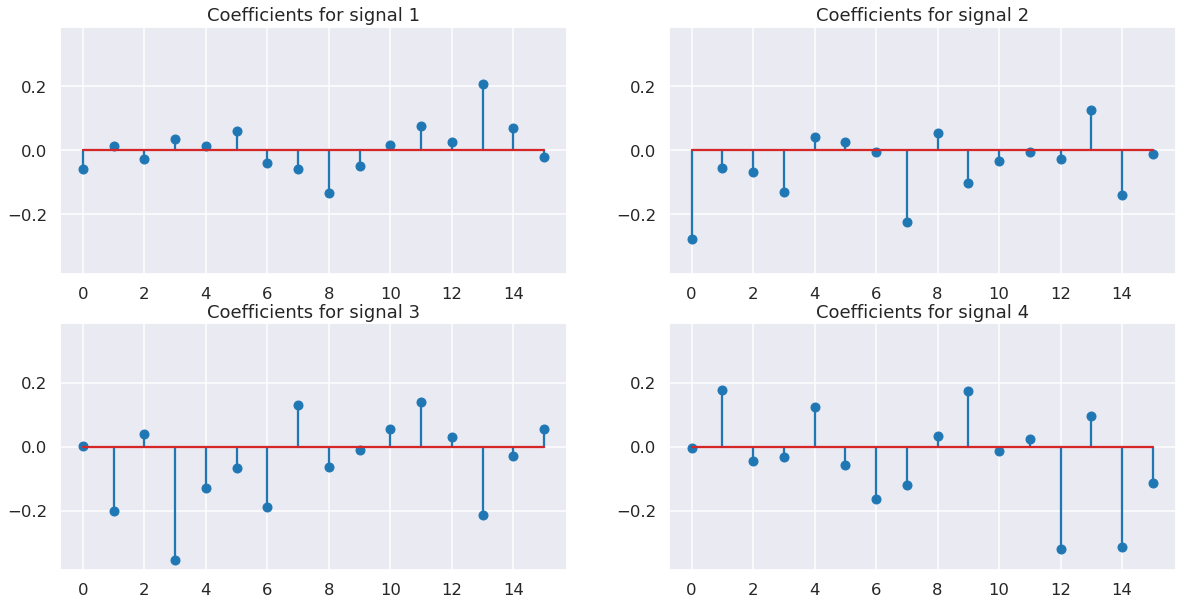

In [226]:
# Print some of the bases and coefficients
Z_rank = np.argsort(np.mean(np.abs(Z_post_mean), axis=0))[::-1]
plot_bases(2, 2, D_post_mean[Z_rank, :], D_post_var[Z_rank, :])
plot_coefficients(2, 2, Z_post_mean[Z_rank, :])

In [198]:
m2 = Model()
m2.Z = Laplace.define_variable(location=broadcast_to(zero, (m_train, k)), scale=broadcast_to(one, (m_train, k)), shape=(m_train, k))
m2.D = Normal.define_variable(mean=broadcast_to(zero, (k, n)), variance=broadcast_to(one, (k, n)), shape=(k, n))
m2.X = Normal.define_variable(mean=dot(m2.Z, m2.D), variance=broadcast_to(Variable(shape=(1,), transformation=PositiveTransformation()), (m_train, n)), shape=(m_train, n))

q_r = Posterior(m2)


q.Z.set_prior(Normal(mean=infr1.params[q.Z.factor.mean], variance=infr1.params[q.Z.factor.variance]))
q.D.set_prior(Normal(mean=infr1.params[q.D.factor.mean], variance=infr1.params[q.D.factor.variance]))
q.X.set_prior(Normal(mean=0, variance=1e-1)) # variance=infr1.params[q.X.factor.variance]))

# q_r.Z.set_prior(q.Z.clone_subgraph())
# q_r.D.set_prior(q.D.clone_subgraph())
# q_r.X.set_prior(Normal(mean=0, variance=1))

svi = StochasticVariationalInference(model=m2, num_samples=10, observed=[model.X], posterior=q_r)
infr2 = GradBasedInference(inference_algorithm=svi, grad_loop=BatchInferenceLoop())
infr2.initialize()

KeyError: 'X'

In [ ]:
# Plot a couple of reconstructions along with the coefficient vectors
idxs = [0, 10, 100]

fig, axs = plt.subplots(len(idxs), 2, figsize=(20, 5 * len(idxs)))
axs = axs.flatten()

for i, idx in enumerate(idxs):
    plot_reconstruction(axs[2 * i], axs[2 * i + 1], df1_test.values[idx, :], reconstructions[idx, :], Z[idx, :])